In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())

# 1. 시청기록

In [2]:
import pandas as pd
import json

with open("data.json", "r", encoding="UTF-8") as f: 
    contents = f.read() # string 타입 
    json_data = json.loads(contents)

In [4]:
json_data[2536]['subtitles'][0]['name']

'웃긴영상다이씀'

In [5]:
json_data[0]

{'header': 'YouTube',
 'title': '[sub]🧳ep.1-2｜인물퀴즈 역사상 가장 뻔뻔한(?) 고객님들의 등장｜🧳출장 십오야2 을(를) 시청했습니다.',
 'titleUrl': 'https://www.youtube.com/watch?v=whjJcz-Gc8g',
 'subtitles': [{'name': '채널 십오야',
   'url': 'https://www.youtube.com/channel/UCQ2O-iftmnlfrBuNsUUTofQ'}],
 'time': '2022-04-12T11:36:29.081Z',
 'products': ['YouTube'],
 'activityControls': ['YouTube 시청 기록']}

In [6]:
len(json_data)

25200

## 전처리

In [7]:
title = []
subtitles = []
time = []

for i in range(len(json_data)):
    try:
        title.append(json_data[i]['title'])
        subtitles.append(json_data[i]['subtitles'][0]['name'])
        time.append(json_data[i]['time'])
    except:
        subtitles.append(0)
        time.append(0)

In [8]:
len(title), len(subtitles), len(time)

(25200, 25200, 25200)

In [9]:
ytb_hist = pd.DataFrame({"title" : title, 
                            "subtitles" : subtitles,
                            "time" : time})

In [10]:
ytb_hist = ytb_hist.query('subtitles != 0').reset_index(drop=True)

In [12]:
# 영상 타이틀만 뽑아내기
ytb_hist['title'] = ytb_hist['title'].apply(lambda x : x.split('을(를)')[0])

In [14]:
ytb_hist['time'] = pd.to_datetime(ytb_hist['time'])

In [15]:
# tz 변경(UTC -> KST)
import pytz
UTC = pytz.timezone('UTC')
KST = pytz.timezone('Asia/Seoul')

# now의 시간대 정보를 UTC로 설정하여 now_utc에 할당
ytb_hist['time'] = ytb_hist['time'].apply(lambda d : d.replace(tzinfo=UTC))

# now_utc의 시간대를 한국 시간대로 변환하여 now_kst에 할당
ytb_hist['time'] = ytb_hist['time'].apply(lambda d : d.astimezone(KST))

In [16]:
ytb_hist['time']

0       2022-04-12 20:36:29.081000+09:00
1       2022-04-12 15:40:00.647000+09:00
2       2022-04-12 13:56:34.464000+09:00
3       2022-04-12 13:56:28.847000+09:00
4       2022-04-12 13:56:11.524000+09:00
                      ...               
22395   2021-12-01 11:40:25.200000+09:00
22396   2021-12-01 11:40:23.746000+09:00
22397   2021-12-01 11:40:02.191000+09:00
22398   2021-12-01 11:39:25.123000+09:00
22399   2021-12-01 11:39:21.574000+09:00
Name: time, Length: 22400, dtype: datetime64[ns, Asia/Seoul]

In [17]:
ytb_hist['time'] = pd.to_datetime(ytb_hist['time'])

In [18]:
# 날짜
ytb_hist['연도'] = ytb_hist['time'].dt.year
ytb_hist['월'] = ytb_hist['time'].dt.month
ytb_hist['일'] = ytb_hist['time'].dt.day
ytb_hist['요일'] = ytb_hist['time'].dt.weekday

# 시간
ytb_hist['시'] = ytb_hist['time'].dt.hour
ytb_hist['분'] = ytb_hist['time'].dt.minute

In [19]:
ytb_hist.head()

,title,subtitles,time,연도,월,일,요일,시,분
0,[sub]🧳ep.1-2｜인물퀴즈 역사상 가장 뻔뻔한(?) 고객님들의 등장｜🧳출장 십...,채널 십오야,2022-04-12 20:36:29.081000+09:00,2022,4,12,1,20,36
1,4강에서 만난 아프리카 4대정글러 【J의 의지】,저라뎃 JUSTLIKETHAT,2022-04-12 15:40:00.647000+09:00,2022,4,12,1,15,40
2,"[클립]깨박이가 전화했을 때, 꽃벼리의 첫마디 -여보.",richard newman,2022-04-12 13:56:34.464000+09:00,2022,4,12,1,13,56
3,클립깨박이의 배려 ♡♡♡꽃벼리의 진심,richard newman,2022-04-12 13:56:28.847000+09:00,2022,4,12,1,13,56
4,강남 100평 오피스텔 ✨️ 새 보금자리 인테리어 대공개 🏠 Home Tour,꽃벼리,2022-04-12 13:56:11.524000+09:00,2022,4,12,1,13,56


In [20]:
ytb_hist['연도'].value_counts()

2022    16427
2021     5973
Name: 연도, dtype: int64

In [34]:
hist22 = ytb_hist.query('연도 == 2022').reset_index(drop=True)
hist21 = ytb_hist.query('연도 == 2021').reset_index(drop=True)

In [35]:
ytb_hist.to_csv('youtube_title.csv')

In [36]:
import gc
gc.collect()

18

## title

### TDM 생성

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [25]:
from kiwipiepy import Kiwi, Option
kiwi = Kiwi(num_workers=4, options=Option.LOAD_DEFAULT_DICTIONARY | Option.INTEGRATE_ALLOMORPH)
# kiwi.load_user_dictionary('user_dictionary.txt')
kiwi.prepare()

In [116]:
korean_stopwords = pd.read_csv('korean_stopwords.txt', header=None)
korean_stopwords.columns = ['stopwords']

In [117]:
def extract_keywords(text):
    result = kiwi.analyze(text)
    for token, pos, start, end in result[0][0]:
        if (pos[0] in 'N') and (token not in list(korean_stopwords['stopwords'])) and (pos[0] != 'NNB'):
            yield f'{token}'
        elif (pos[0] in 'V') and (len(token)>=2):
            yield f'{token}'

In [118]:
cv = CountVectorizer(max_features=200, tokenizer=extract_keywords, stop_words=list(korean_stopwords['stopwords']))

In [119]:
tfidf = TfidfTransformer()

In [120]:
tdm22 = cv.fit_transform(hist22['title'])
tdm21 = cv.fit_transform(hist21['title'])

C:\Users\jinho\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '게우', '견지', '결과', '결론', '고려', '공동', '관계', '관련', '관하', '구체', '구토', '그러', '그렇', '그치', '근거', '기대', '기여', '기점', '기준', '까닭', '나머지', '논', '놀라', '다르', '달리', '답', '대로', '대하', '댕', '더불', '도달', '도착', '동시', '뒤잇', '득', '든간', '따르', '따름', '라', '랜덤', '르', '막론하', '만큼', '메쓰겁', '모르', '무릎', '바', '바꾸', '밖', '반대', '방면', '보드', '부류', '불', '불구하', '불문', '비걱거리', '비교', '비기', '비슷하', '비추', '비하', '삐걱거리', '사람', '상대', '생각', '서술', '션', '시작', '시초', '시키', '쓰이', '아래', '아무', '아무거', '앞', '어떻', '어쩌', '연관', '연이', '옆', '오르', '요만하', '용비', '위하', '의거', '의지', '의하', '의해되', '이러이러하', '이렇', '이르', '이외', '이용', '이제', '인', '인하', '일반', '입각', '입장', '잇', '적', '정도', '제외', '종합', '주저', '중의', '즈음', '지경', '집', '쪽', '차', '총', '켠', '토하', '통하', '틀림없', '틈', '하게', '한하', '항목', '해', '향', '향하', '형식', '힘', '힘입'] not in stop_words.
  warnings.warn('You

In [121]:
tdm22_2 = tfidf.fit_transform(tdm22)
tdm21_2 = tfidf.fit_transform(tdm21)

In [122]:
word_count22 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm22.sum(axis=0).flat
})

In [123]:
word_count21 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm21.sum(axis=0).flat
})

In [124]:
word_count22_2 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm22_2.sum(axis=0).flat
})

In [125]:
word_count21_2 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm21_2.sum(axis=0).flat
})

In [126]:
word_count22.sort_values('빈도', ascending=False).head(10)

,단어,빈도
190,한우,314
20,김종국,265
91,셰프,249
155,차,244
71,법,242
46,라이브,238
68,방법,231
83,생각,195
154,집,172
66,밤,169


In [127]:
word_count21.sort_values('빈도', ascending=False).head(10)

,단어,빈도
138,이재명,101
132,윤석열,101
97,쇼,89
186,피파,89
68,방법,80
154,집,77
24,남자,70
78,사람,69
50,레전드,69
46,라이브,69


In [128]:
word_count22_2.sort_values('빈도', ascending=False).head(10)

,단어,빈도
190,한우,207.662887
71,법,192.313189
68,방법,182.925227
20,김종국,174.963420
155,차,162.845313
46,라이브,162.776907
91,셰프,141.284072
83,생각,141.208348
154,집,125.062645
75,부르,122.863022


In [129]:
word_count21_2.sort_values('빈도', ascending=False).head(10)

,단어,빈도
138,이재명,69.620352
132,윤석열,65.403490
68,방법,61.920081
97,쇼,56.677747
186,피파,50.834477
24,남자,50.825432
78,사람,50.045994
154,집,49.438018
71,법,49.054666
22,나오,48.527341


### Word Cloud

In [130]:
count_dic22 = word_count22.set_index('단어')['빈도'].to_dict()
count_dic21 = word_count21.set_index('단어')['빈도'].to_dict()

count_dic22_2 = word_count22_2.set_index('단어')['빈도'].to_dict()
count_dic21_2 = word_count21_2.set_index('단어')['빈도'].to_dict()

In [131]:
from wordcloud import WordCloud

In [132]:
wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
               background_color='white', max_words=30,
               width=400, height=300)

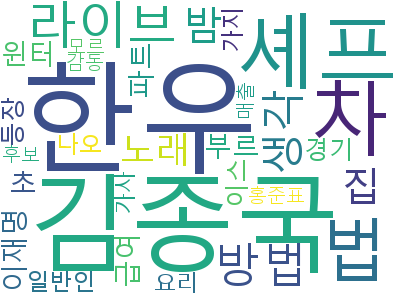

In [133]:
cloud22 = wc.generate_from_frequencies(count_dic22)
cloud22.to_image()

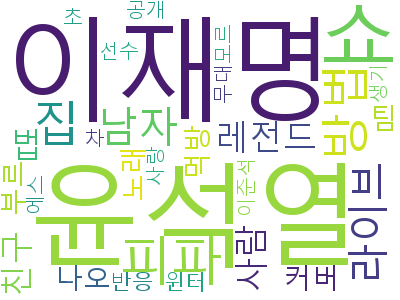

In [134]:
cloud21 = wc.generate_from_frequencies(count_dic21)
cloud21.to_image()

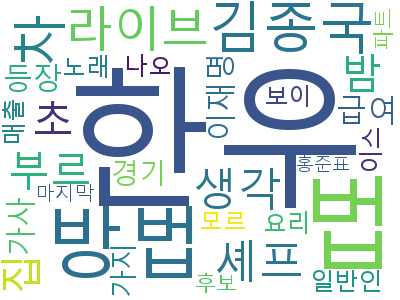

In [135]:
cloud22_2 = wc.generate_from_frequencies(count_dic22_2)
cloud22_2.to_image()

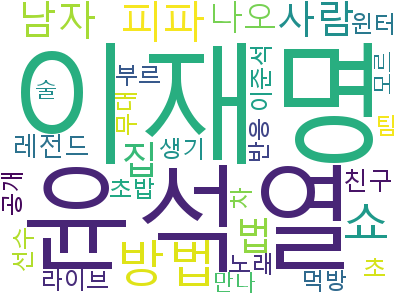

In [136]:
cloud21_2 = wc.generate_from_frequencies(count_dic21_2)
cloud22_2.to_image()

### title을 word embedding하고 클러스터링을 해보까

In [57]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen

In [58]:
ytb_hist['title']

0        [sub]🧳ep.1-2｜인물퀴즈 역사상 가장 뻔뻔한(?) 고객님들의 등장｜🧳출장 십...
1                              4강에서 만난 아프리카 4대정글러 【J의 의지】 
2                          [클립]깨박이가 전화했을 때, 꽃벼리의 첫마디 -여보. 
3                                    클립깨박이의 배려 ♡♡♡꽃벼리의 진심 
4             강남 100평 오피스텔 ✨️ 새 보금자리 인테리어 대공개 🏠 Home Tour 
                               ...                        
22395                             [스우파] 적극적인 노제와 받아주는 아이키 
22396                                     서) 그래비트랙스 ver.2 
22397              츄: 브라운 팔아달라구요? 안돼요! 네? 200에 산다구요?! 자요! 
22398    야구공 하나로 타격폼 교정하는 양준혁  클라스 ㄷㄷ 괜히 레전드가 아니구나.. #s...
22399                                   여자들이 쌍수를 하는이유 급존예 
Name: title, Length: 22400, dtype: object

In [59]:
# 문장 전처리
def PreProcessingText(input_sentence):
    input_sentence = input_sentence.lower() # 소문자화
    input_sentence = re.sub('<[^>]*>', repl= ' ', string = input_sentence) # "<br />" 처리
    input_sentence = re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', repl= ' ', string = input_sentence) # 특수문자 처리 ("'" 제외)
    input_sentence = re.sub('\s+', repl= ' ', string = input_sentence) # 연속된 띄어쓰기 처리
    input_sentence = re.sub('[^ㄱ-ㅣ가-힣]+', repl= ' ', string = input_sentence) # 연속된 띄어쓰기 처리
    return input_sentence

In [60]:
import re
ytb_hist['title'] = ytb_hist['title'].apply(lambda x : PreProcessingText(x))

In [61]:
ytb_hist['title']

0                 인물퀴즈 역사상 가장 뻔뻔한 고객님들의 등장 출장 십오야 
1                           강에서 만난 아프리카 대정글러 의 의지 
2                      클립 깨박이가 전화했을 때 꽃벼리의 첫마디 여보 
3                               클립깨박이의 배려 꽃벼리의 진심 
4                       강남 평 오피스텔 새 보금자리 인테리어 대공개 
                           ...                    
22395                       스우파 적극적인 노제와 받아주는 아이키 
22396                                    서 그래비트랙스 
22397                츄 브라운 팔아달라구요 안돼요 네 에 산다구요 자요 
22398    야구공 하나로 타격폼 교정하는 양준혁 클라스 ㄷㄷ 괜히 레전드가 아니구나 
22399                           여자들이 쌍수를 하는이유 급존예 
Name: title, Length: 22400, dtype: object

In [63]:
!pip install fasttext

  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Running setup.py clean for fasttext
Failed to build fasttext
    Running setup.py install for fasttext: started
    Running setup.py install for fasttext: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\jinho\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\jinho\\AppData\\Local\\Temp\\pip-install-oaqk90qj\\fasttext_c6f6fb8af73c48a1b5dd22a536386c45\\setup.py'"'"'; __file__='"'"'C:\\Users\\jinho\\AppData\\Local\\Temp\\pip-install-oaqk90qj\\fasttext_c6f6fb8af73c48a1b5dd22a536386c45\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\jinho\AppData\Local\Temp\pip-wheel-j1l3dbjz'
       cwd: C:\Users\jinho\AppData\Local\Temp\pip-install-oaqk90qj\fasttext_c6f6fb8af73c48a1b5dd22a536386c45\
  Complete output (30 lines):
  C:\Users\jinho\anaconda3\lib\site-packages\setuptools\dist.py:717: UserWarning: Usage of dash-separated 'desc

In [64]:
import fasttext.util
fasttext.util.download_model('ko', if_exists='ignore')  # English
ft = fasttext.load_model('cc.ko.300.bin')

ModuleNotFoundError: No module named 'fasttext'

In [28]:
from gensim import models

ko_model = models.fasttext.load_facebook_model('cc.ko.300.bin')

In [29]:
from tqdm import tqdm

sentence_vector = []
for title in tqdm(ytb_hist['title']):
    tmp = np.zeros(300)
    cnt = 0
    for word in title:
        try:
            tmp += ko_model.wv.word_vec(word)
            cnt += 1
        except:
            pass
    tmp /= cnt
    sentence_vector.append(tmp)
sentence_vector = np.array(sentence_vector)

100%|██████████████████████████████████████████████████████████████████████████| 21710/21710 [00:11<00:00, 1875.53it/s]


In [30]:
len(sentence_vector)

21710

In [31]:
sentence_vector = pd.DataFrame(sentence_vector)
sentence_vector.columns = sentence_vector.columns.astype(str) + "_title"
ytb_hist = pd.concat([ytb_hist, sentence_vector], axis=1)

In [33]:
ytb_hist.shape

(21710, 309)

In [39]:
# 군집 수 정하기
wss=[]
for k in np.arange(1, 20):
    km_k = KMeans(n_clusters=k).fit(ytb_hist.iloc[:, 9:])
    wss.append(km_k.inertia_)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
wss

In [ ]:
plt.plot(np.arange(1, 20),wss)
plt.xlabel('K')
plt.ylabel('WSS')
plt.show()

In [41]:
ytb_hist = ytb_hist.drop('cluster_title', axis=1)

In [42]:
# 군집분석
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4).fit(ytb_hist.iloc[:, 9:])

ytb_hist['cluster_title'] = km.labels_
ytb_hist['cluster_title'] = ytb_hist['cluster_title'].astype('category')

ytb_hist.cluster_title.value_counts()

1    12000
2     8469
0      898
3      343
Name: cluster_title, dtype: int64

Text(0.5, 1.0, '군집별 시청횟수')

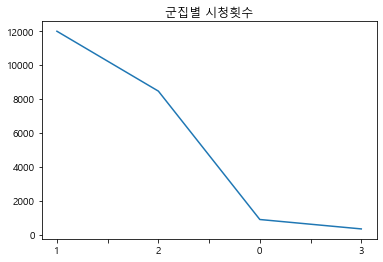

In [138]:
ytb_hist.cluster_title.value_counts().plot()
plt.title('군집별 시청횟수')

In [40]:
ytb_hist.columns

Index(['title', 'subtitles', 'time', '연도', '월', '일', '요일', '시', '분', '0_title',
       ...
       '291_title', '292_title', '293_title', '294_title', '295_title',
       '296_title', '297_title', '298_title', '299_title', 'cluster_title'],
      dtype='object', length=310)

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="0_title", y="1_title", hue="cluster_title", style="cluster_title", data=ytb_hist)
for i in range(ytb_hist.shape[0]):
    plt.text(x=ytb_hist['0_title'][i]+0.01, 
            y=ytb_hist['1_title'][i]+0.01,
            s=ytb_hist.index[i],
            color=sns.color_palette()[ytb_hist.cluster_title[i]])
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,3], marker="x", s=100,
            color=sns.color_palette()[:4])
plt.show()

KeyboardInterrupt: 

In [98]:
# cluster_title == 0 : 개그, 게임
ytb_hist.query('cluster_title == 0')['title'].sample(10)

17839     어떠한 사소한 장점으로도 직업을 추천해드립니다ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 
15432                     아이즈원 한국인 종특 ㅋㅋㅋㅋㅋㅋ 
8288          아이즈원 레전드 ㅋㅋㅋ 예나 진짜 예능신이야 ㅋㅋㅋㅋㅋ 
9150     제 회 스타 빅매치 나몰라패밀리 피식대학 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 
13338                                     뚝꾹 
5645               한국한테 참교육 당해버린 중국 국가대표팀ㅋㅋㅋ 
17889         오버워치 변호인패러디 한조인 ㅋㅋㅋㅋㅋㅋㅋ 돌았네 레알 
5513                    부산맵 컨뚫빌드 거부존 쌉레전듴ㅋㅋㅋ 
9194     직업별 말투 성대모사ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 인강강사 아나운서 나레이터 
10299                      사악한 타이탄군단 출동ㅋㅋㅋㅋㅋ 
Name: title, dtype: object

In [95]:
# cluster_title == 1 : 스포츠, 운동, 예능
ytb_hist.query('cluster_title == 1')['title'].sample(10)

21035                   최영훈의 교과서급 디펜스 그때 그 경기 카트라이더 리그 시즌 
13649                진정한 간지 투우사 최영훈 카트라이더 리그 시즌 개막전 하이라이트 
9410              마선호 선수가 대보협에 나가지 않는 이유ㅣ내추럴 보디빌더 마선호 인터뷰 
6621            송중기 한껏 꾸민 전여빈의 연수원 동기모임 행차에 심기불편ㅋㅋ 빈센조 방송 
2461               억 장전 월드컵 우승 그시절 스페인 무적함대 완성 비야 부활시킴 피파 
2293         기안 최초의 울분 박나래와의 불화를 애써 외면하는 이유 침착맨이 꺼낸 개의 비밀 
4618     갤럭시를 쓴다면 무조건 무료 안보면 손해인 핵꿀기능 가지 설정방법 갤럭시 노트 세팅하기 
15488                               오마이걸 효정 현아도 본 효정의 버블팝 
1930                          직접 겪은 김준호 선수의 황제헬스 실제로 혼난 썰 
389                       붐 뼈때리는 장영란 웃겨서 숨 넘어가는 태연 놀라운토요일 
Name: title, dtype: object

In [122]:
# cluster_title == 2 : 아이즈원 컨텐츠, 음악컨텐츠
ytb_hist.query('cluster_title == 2')['title'].sample(10)

12647                       아케이드 도망가자 선우정아 
11129                              게스트랑친한척 
8827                     빈첸 늘ㅣ 바래 마이크스웨거부스 
19436                       머쉬베놈 고등래퍼 지원영상 
18565     놀라운토요일 비글미 폭발 걸스데이 웃음지뢰 모음 의 팬클럽 
7157                 아이즈원 브이라이브 하이라이트 조유리편 
1970                      비와이 마에스트로 쇼츠 데자부 
16530                        홈짐에 드디어 오셨습니다 
18306                   아이즈원 잔망 쌈아치 차원 밍구리 
16619                 아이즈원 최예나 허세부리는 오리 사냥 
Name: title, dtype: object

In [133]:
# cluster_title == 3 : 영어제목, 외계어
ytb_hist.query('cluster_title == 3')['title'].sample(10)

5582        
12972       
3813      먛 
18059       
16896       
4327        
731      개쉨 
1854        
7062        
4675      먛 
Name: title, dtype: object

In [125]:
# cluster_title == 4 : 초성이 많이 포함됨, 게임, 아이즈원, 개그
#ytb_hist.query('cluster_title == 4')['title'].iloc[100:140]

<AxesSubplot:xlabel='시'>

C:\Users\leeji\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\leeji\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


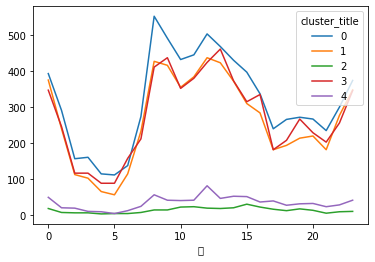

In [244]:
# 시간별로 어떤 군집에 해당하는 영상을 많이 보는지
a = ytb_hist.groupby(['시'])['cluster_title'].value_counts().unstack()
a.plot()

## subtitles

In [194]:
a = ytb_hist['subtitles'].value_counts().reset_index()
b = a.query('subtitles >= 100')

In [195]:
b

,index,subtitles
0,런닝맨 - 스브스 공식 채널,530
1,문호준,383
2,MBCentertainment,352
3,Mnet TV,352
4,tvN D ENT,317
5,tvN,285
6,JTBC Entertainment,283
7,디글 :Diggle,280
8,런민기,263
9,놀라운 토요일 Amazing Saturday,240


# 2. 검색기록

In [196]:
import pandas as pd
import json

with open("data/takeout-20211010T114647Z-001/Takeout/YouTube 및 YouTube Music/시청 기록/검색 기록.json", "r", encoding="UTF-8") as f: 
    contents = f.read() # string 타입 
    json_data = json.loads(contents)

In [197]:
json_data

[{'header': 'YouTube',
  'title': '킬링보이스 을(를) 검색했습니다.',
  'titleUrl': 'https://www.youtube.com/results?search_query=%ED%82%AC%EB%A7%81%EB%B3%B4%EC%9D%B4%EC%8A%A4',
  'time': '2021-10-09T02:48:32.254Z',
  'products': ['YouTube']},
 {'header': 'YouTube',
  'title': '킬링보이 을(를) 검색했습니다.',
  'titleUrl': 'https://www.youtube.com/results?search_query=%ED%82%AC%EB%A7%81%EB%B3%B4%EC%9D%B4',
  'time': '2021-10-09T02:48:24.044Z',
  'products': ['YouTube']},
 {'header': 'YouTube',
  'title': '김필 을(를) 검색했습니다.',
  'titleUrl': 'https://www.youtube.com/results?search_query=%EA%B9%80%ED%95%84',
  'time': '2021-10-07T05:36:30.427Z',
  'products': ['YouTube']},
 {'header': 'YouTube',
  'title': '먹방 을(를) 검색했습니다.',
  'titleUrl': 'https://www.youtube.com/results?search_query=%EB%A8%B9%EB%B0%A9',
  'time': '2021-10-05T17:53:51.818Z',
  'products': ['YouTube']},
 {'header': 'YouTube',
  'title': '설문조사 질문에 답변함',
  'subtitles': [{'name': '답변: 해당 사항 없음'}],
  'time': '2021-10-05T15:05:18.235Z',
  'products': ['You

In [246]:
title = []
time = []

for i in range(len(json_data)):
    try:
        title.append(json_data[i]['title'])
        time.append(json_data[i]['time'])
    except:
        time.append(0)

In [247]:
len(title), len(time)

(1405, 1405)

In [248]:
sch_hist = pd.DataFrame({"title" : title,
                         "time" : time})

In [249]:
sch_hist

,title,time
0,킬링보이스 을(를) 검색했습니다.,2021-10-09T02:48:32.254Z
1,킬링보이 을(를) 검색했습니다.,2021-10-09T02:48:24.044Z
2,김필 을(를) 검색했습니다.,2021-10-07T05:36:30.427Z
3,먹방 을(를) 검색했습니다.,2021-10-05T17:53:51.818Z
4,설문조사 질문에 답변함,2021-10-05T15:05:18.235Z
...,...,...
1400,김범수 끝사랑 을(를) 검색했습니다.,2014-03-23T06:45:42.553Z
1401,히든싱어 왕중왕전 을(를) 검색했습니다.,2014-03-23T06:39:56.710Z
1402,쇼미더머니 매드클라운 을(를) 검색했습니다.,2014-03-21T23:24:18.610Z
1403,산이 을(를) 검색했습니다.,2014-03-21T23:15:58.751Z


In [251]:
# 영상 타이틀만 뽑아내기
sch_hist['title'] = sch_hist['title'].apply(lambda x : x.split('을(를)')[0])

In [253]:
sch_hist['time'] = pd.to_datetime(sch_hist['time'])

In [254]:
# tz 변경(UTC -> KST)
import pytz
UTC = pytz.timezone('UTC')
KST = pytz.timezone('Asia/Seoul')

# now의 시간대 정보를 UTC로 설정하여 now_utc에 할당
sch_hist['time'] = sch_hist['time'].apply(lambda d : d.replace(tzinfo=UTC))

# now_utc의 시간대를 한국 시간대로 변환하여 now_kst에 할당
sch_hist['time'] = sch_hist['time'].apply(lambda d : d.astimezone(KST))

In [255]:
# 날짜
sch_hist['연도'] = sch_hist['time'].dt.year
sch_hist['월'] = sch_hist['time'].dt.month
sch_hist['일'] = sch_hist['time'].dt.day
sch_hist['요일'] = sch_hist['time'].dt.weekday

# 시간
sch_hist['시'] = sch_hist['time'].dt.hour
sch_hist['분'] = sch_hist['time'].dt.minute

In [256]:
sch_hist

,title,time,연도,월,일,요일,시,분
0,킬링보이스,2021-10-09 11:48:32.254000+09:00,2021,10,9,5,11,48
1,킬링보이,2021-10-09 11:48:24.044000+09:00,2021,10,9,5,11,48
2,김필,2021-10-07 14:36:30.427000+09:00,2021,10,7,3,14,36
3,먹방,2021-10-06 02:53:51.818000+09:00,2021,10,6,2,2,53
4,설문조사 질문에 답변함,2021-10-06 00:05:18.235000+09:00,2021,10,6,2,0,5
...,...,...,...,...,...,...,...,...
1400,김범수 끝사랑,2014-03-23 15:45:42.553000+09:00,2014,3,23,6,15,45
1401,히든싱어 왕중왕전,2014-03-23 15:39:56.710000+09:00,2014,3,23,6,15,39
1402,쇼미더머니 매드클라운,2014-03-22 08:24:18.610000+09:00,2014,3,22,5,8,24
1403,산이,2014-03-22 08:15:58.751000+09:00,2014,3,22,5,8,15


In [260]:
sch_hist['time'].min(), sch_hist['time'].max()

(Timestamp('2014-03-21 19:43:59.107000+0900', tz='Asia/Seoul'),
 Timestamp('2021-10-09 11:48:32.254000+0900', tz='Asia/Seoul'))

In [261]:
sch_hist['연도'].value_counts()

2021    539
2014    365
2020    241
2015    178
2016     82
Name: 연도, dtype: int64

In [276]:
sch_hist.query('연도 == 2014')['title'].value_counts().head(10)

쇼미더머니3        23
지코            19
신용재           14
지조            11
산이            10
윤민수           10
올티            10
히든싱어 이문세편      9
쇼미더머니          9
싸이퍼            8
Name: title, dtype: int64

In [277]:
sch_hist.query('연도 == 2015')['title'].value_counts().head(10)

마마무        15
신용재        12
불후의명곡2      8
지조          8
허클베리피       7
손승연         6
이선희         6
현아          5
히든싱어        4
빅뱅          4
Name: title, dtype: int64

In [278]:
sch_hist.query('연도 == 2016')['title'].value_counts().head(10)

마마무                  24
아이유 유인나               9
윤민수                   3
윤민수 어느 소녀의 사랑이야기      2
마마무 배호                2
아이유인나                 2
유인나의 볼륨을 높여요          2
원펀맨                   2
지조 프리스타일              2
김필                    1
Name: title, dtype: int64

In [279]:
sch_hist.query('연도 == 2020')['title'].value_counts().head(10)

아이즈원            91
런닝맨             10
공부               6
머쉬베놈             4
싱어게인             4
아이폰12 강화유리       3
아이폰12            3
먹방               2
하트시그널 김현우        2
아이폰12 액정테스트      2
Name: title, dtype: int64

In [280]:
sch_hist.query('연도 == 2021')['title'].value_counts().head(10)

아이즈원         118
먹방            22
1박2일          12
런닝맨           10
몬스터짐           8
너의번호를누르고       8
싱어게인           8
최준             7
풀업             7
악마판사           6
Name: title, dtype: int64